## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.

In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.tree import export_text

### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

In [24]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-21 17:17:39--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1.36M  4.54MB/s    in 0.3s    

2023-10-21 17:17:40 (4.54 MB/s) - ‘housing.csv.1’ saved [1423529/1423529]



In [25]:
df = pd.read_csv("housing.csv")

### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

In [26]:
df = df.loc[(df.ocean_proximity == '<1H OCEAN') | (df.ocean_proximity == 'INLAND')].reset_index(drop=True)

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [27]:
# fill missing values with 0
df.fillna(0,inplace=True)
# Apply the log transform to `median_house_value`.
df['median_house_value'] =  df['median_house_value'].apply(lambda x : np.log1p(x))

In [28]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,12.973866,<1H OCEAN
1,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,12.287657,<1H OCEAN
2,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,12.419574,<1H OCEAN
3,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,12.554971,<1H OCEAN
4,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,12.287196,<1H OCEAN


In [34]:
# Do train/validation/test split with 60%/20%/20% distribution.
# Use the `train_test_split` function and set the `random_state` parameter to 1.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# reset the indices for prettiness
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.copy()
y_val = df_val.median_house_value.copy()
y_test = df_test.median_house_value.copy()

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [37]:
# Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `------>ocean_proximity`
* `total_rooms`
* `latitude`
* `population`




In [39]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [40]:
print(export_text(dtr, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* ``0.245``
* 0.545
* 0.845




In [42]:
# Init random forest regressor model
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
# fit model on training data
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [44]:
#get predictions
y_pred = rfr.predict(X_val)

In [49]:
print('%.3f' % mean_squared_error(y_val, y_pred, squared=False))

0.245


In [51]:
#from ml_metrics import rmse
#rmse(actual=[0, 1, 2], predicted=[1, 10, 5])

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

In [57]:
def get_best_num_estimatots():
    scores = []

    for n in range(10, 201, 10):
        rfr = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
        rfr.fit(X_train, y_train)

        y_pred = rfr.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        scores.append((n, rmse))
    
    df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
    return df_scores

In [59]:
df_scores = get_best_num_estimatots()

After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- ``160``

https://stackoverflow.com/questions/24988448/how-to-draw-vertical-lines-on-a-given-plot

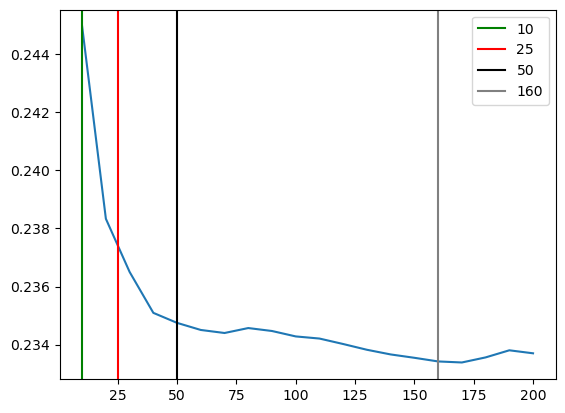

In [65]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.axvline(x=10, color='green', label='10')
plt.axvline(x=25, color='red', label='25')
plt.axvline(x=50, color='black', label='50')
plt.axvline(x=160, color='grey', label='160')

plt.legend()

In [69]:
print(df_scores.round(3))

    n_estimators   rmse
0             10  0.245
1             20  0.238
2             30  0.237
3             40  0.235
4             50  0.235
5             60  0.235
6             70  0.234
7             80  0.235
8             90  0.234
9            100  0.234
10           110  0.234
11           120  0.234
12           130  0.234
13           140  0.234
14           150  0.234
15           160  0.233
16           170  0.233
17           180  0.234
18           190  0.234
19           200  0.234


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [71]:
def get_best_num_estimators_and_depth():
    scores = []
    
    for md in [10, 15, 20, 25]:
        for n in range(10, 201, 10):        
            rfr = RandomForestRegressor(n_estimators=n, 
                                        max_depth=md,
                                        random_state=1, 
                                        n_jobs=-1)
            rfr.fit(X_train, y_train)

            y_pred = rfr.predict(X_val)
            rmse = mean_squared_error(y_val, y_pred, squared=False)

            scores.append((md, n, rmse))           
    
    df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])
    return df_scores

In [72]:
df_scores2 = get_best_num_estimators_and_depth()

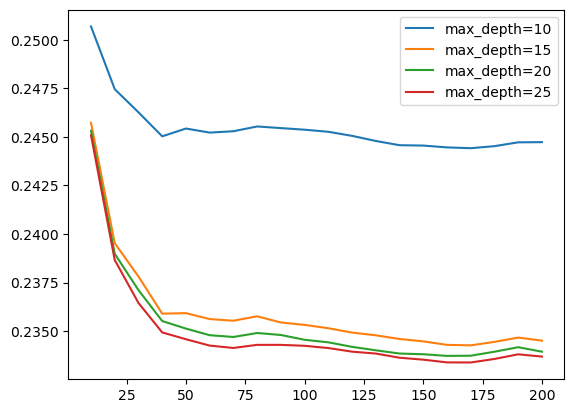

In [75]:
for md in [10, 15, 20, 25]:
    df_subset = df_scores2[df_scores2.max_depth == md]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % md)

plt.legend()

### How to do group by
https://stackoverflow.com/questions/26599347/groupby-pandas-dataframe-and-calculate-mean-and-stdev-of-one-column

In [102]:
df_scores2.groupby("max_depth")['rmse'].agg(['mean']).reset_index().round(4)#, 'std'

,max_depth,mean
0,10,0.2454
1,15,0.2359
2,20,0.2353
3,25,0.2349


In [85]:
#df_copy = df_scores2.groupby("max_depth")['rmse'].agg(['mean'])

In [103]:
#df_copy.reset_index(inplace=True)

In [100]:
#df_scores_pivot = df_copy.pivot(index='max_depth', columns=['mean'], values=['mean'])
#df_scores_pivot.round(4)
#sns.heatmap(df_scores_pivot, annot=True, fmt=".4f")

In [105]:
#del df_copy

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model

https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances

In [151]:
def q5_model():#
    features = dv.get_feature_names_out()
    rfr = RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1,)
    
    rfr.fit(X_train, y_train)
    
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(dv.get_feature_names_out(), rfr.feature_importances_):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    return importances

In [152]:
imp = q5_model()

<Axes: >

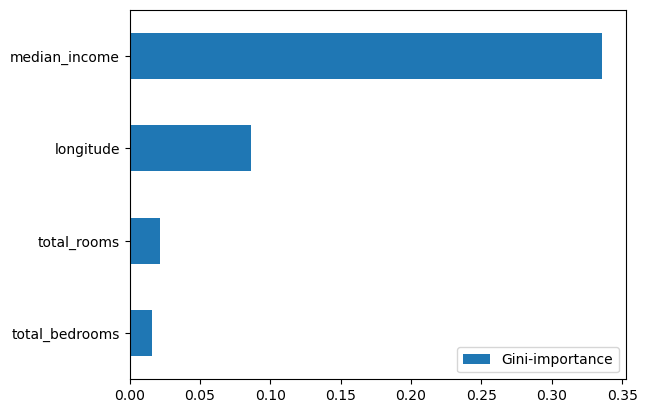

In [156]:
imp[imp.index.isin(['total_rooms','median_income','total_bedrooms','longitude'])].sort_values(by='Gini-importance').plot(kind='barh')

In [157]:
#imp.sort_values(by='Gini-importance').plot(kind='barh')#, rot=90

What's the most important feature (among these 4)? 

* `total_rooms`
* --------------->`median_income`
* `total_bedrooms`
* `longitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [168]:
#!pipenv install xgboost

In [167]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 5.1 MB/s eta 0:00:00m eta 0:00:010:00:01


In [188]:
def q6_model(eta):
    
    features = dv.get_feature_names_out()
    # have to remove special chars from names else XGboost complains about it
    features= [i.replace("=<", "_").replace("=","_") for i in features]
    
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
    
    
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
    
        'objective': 'reg:squarederror',
        'nthread': 8,
    
        'seed': 1,
        'verbosity': 1,
    }
    #watchlist = [(dtrain, 'train'), (dval, 'val')]
    #%%capture output 
    model = xgb.train(xgb_params, dtrain, num_boost_round=100)
    
    y_pred = model.predict(dval)
    
    print('%.3f' % mean_squared_error(y_val, y_pred, squared=False))
    #s = output.stdout
    #return y_pred

In [189]:
q6_model(eta=0.3)

/home/majeedk/anaconda3/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


0.229


In [190]:
q6_model(eta=0.1)

/home/majeedk/anaconda3/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


0.232


## Testing code from class

In [192]:
features = dv.get_feature_names_out()
# have to remove special chars from names else XGboost complains about it
features= [i.replace("=<", "_").replace("=","_") for i in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

/home/majeedk/anaconda3/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [193]:
scores = {}

In [194]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [195]:
%%capture output

xgb_params = {
        'eta': 0.3, 
        'max_depth': 6,
        'min_child_weight': 1,
    
        'objective': 'reg:squarederror',
        'nthread': 8,
    
        'seed': 1,
        'verbosity': 1,
    }

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [196]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [197]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

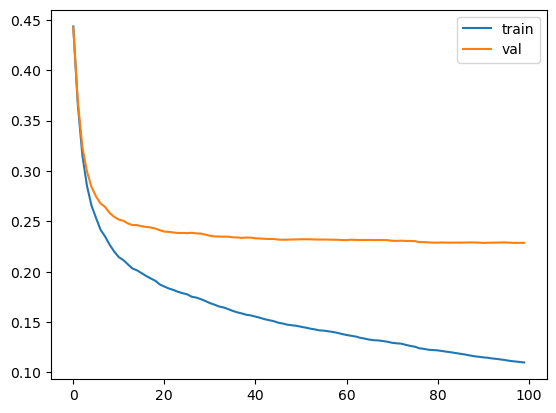

In [201]:
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].train_auc, label='train')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='val')
plt.legend()

In [202]:
%%capture output

xgb_params = {
        'eta': 0.1, 
        'max_depth': 6,
        'min_child_weight': 1,
    
        'objective': 'reg:squarederror',
        'nthread': 8,
    
        'seed': 1,
        'verbosity': 1,
    }

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [203]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

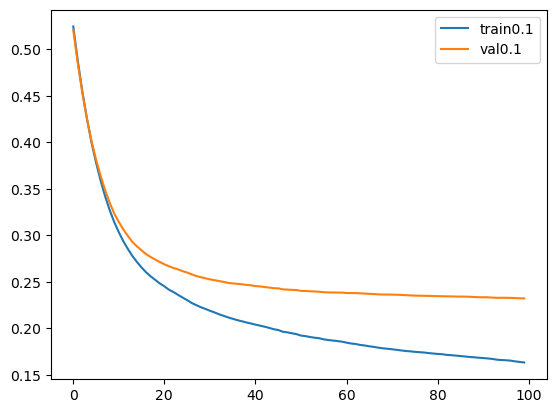

In [206]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].train_auc, label='train0.1')
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='val0.1')


plt.legend()

# comparison

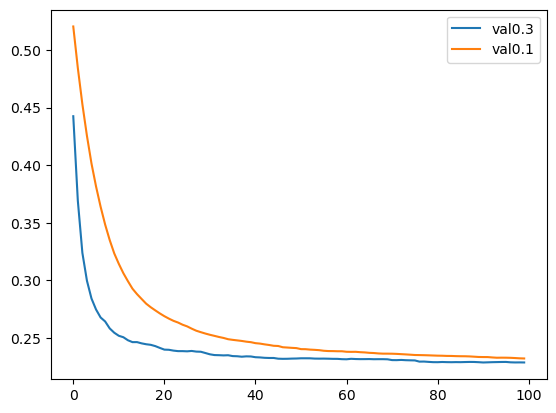

In [209]:
#plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].train_auc, label='train0.3')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='val0.3')

#plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].train_auc, label='train0.1')
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='val0.1')

#plt.xlim(90, 101)
plt.legend()

## Submit the results

- Submit your results here: https://forms.gle/Qa2SuzG7QGZNCaoV9
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is October 23 (Monday), 23:00 CET. After that the form will be closed.